# Задание
1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю сделайте ее перрасчет (ресемплинг) в представление по неделям.
3. Постройте модель предсказания 1-й точки от текущей (h=1).
4. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

### Задача 1

Импортируем библиотеки

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import os

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Прочитаем csv-файл

In [15]:
brent = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Определим датафрейм с первыми разностями

In [22]:
brent_diff_values = brent['Значение'].values[1:]- brent['Значение'].values[:-1]
brent_diff = pd.DataFrame(data = brent_diff_values, index = brent.index[:2666], columns=['Значение'])
brent_diff

,Значение
Дата,
2010-09-01,0.52
2010-09-02,-0.32
2010-09-03,0.05
2010-09-04,0.01
2010-09-05,0.24
2010-09-06,0.39
2010-09-07,0.67
2010-09-08,-0.72
2010-09-09,1.20


### Задача 2

Прочитаем csv-файл с курсом валют и создадим датафрейм с первыми разностями

In [13]:
usd = pd.read_excel(io='RC_F01_09_2010_T01_09_2019.xlsx', index_col='data', usecols=[1, 2])
usd.head()

,curs
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [25]:
usd_values = usd['curs'].values[1:]- usd['curs'].values[:-1]
usd_diff = pd.DataFrame(data = usd_values, index = usd.index[:2227], columns=['curs_usd'])
usd_diff

,curs_usd
data,
2010-09-01,-0.0668
2010-09-02,-0.1143
2010-09-03,0.0064
2010-09-04,-0.1151
2010-09-07,0.1548
2010-09-08,0.1554
2010-09-09,-0.0072
2010-09-10,0.0136
2010-09-11,-0.2106


In [14]:
euro = pd.read_excel(io='R_E01_09_2010_T01_09_2019.xlsx', index_col='data', usecols=[1, 2])
euro.head()

,curs
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [26]:
euro_values = euro['curs'].values[1:]- euro['curs'].values[:-1]
euro_diff = pd.DataFrame(data = euro_values, index = euro.index[:2227], columns=['curs_euro'])
euro_diff.head()

,curs_euro
data,
2010-09-01,0.1527
2010-09-02,0.1247
2010-09-03,0.0604
2010-09-04,0.1215
2010-09-07,-0.1505


Соединим все датафреймы в один

In [38]:
total = pd.concat([usd_diff, euro_diff], axis=1)
total = pd.concat([brent_diff, total], axis=1)
total = total.dropna()

,Значение,curs_usd,curs_euro
2010-09-01,0.52,-0.0668,0.1527
2010-09-02,-0.32,-0.1143,0.1247
2010-09-03,0.05,0.0064,0.0604
2010-09-04,0.01,-0.1151,0.1215
2010-09-07,0.67,0.1548,-0.1505
2010-09-08,-0.72,0.1554,-0.0267
2010-09-09,1.20,-0.0072,-0.1080
2010-09-10,-0.05,0.0136,0.0049
2010-09-11,0.83,-0.2106,0.1318
2010-09-14,0.10,0.0218,0.2029


Произведем ресемплинг

In [41]:
total_w = total.resample('W').mean()
total_w.head()

,Значение,curs_usd,curs_euro
2010-09-05,0.0650,-0.072450,0.114825
2010-09-12,0.3860,0.021200,-0.029700
2010-09-19,-0.2175,0.099875,0.372000
2010-09-26,0.2100,-0.008225,0.179575
2010-10-03,1.2100,-0.025625,0.109650


### Задача 3 -- 4

Разделим данные на тестовые и тренировочные

In [50]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

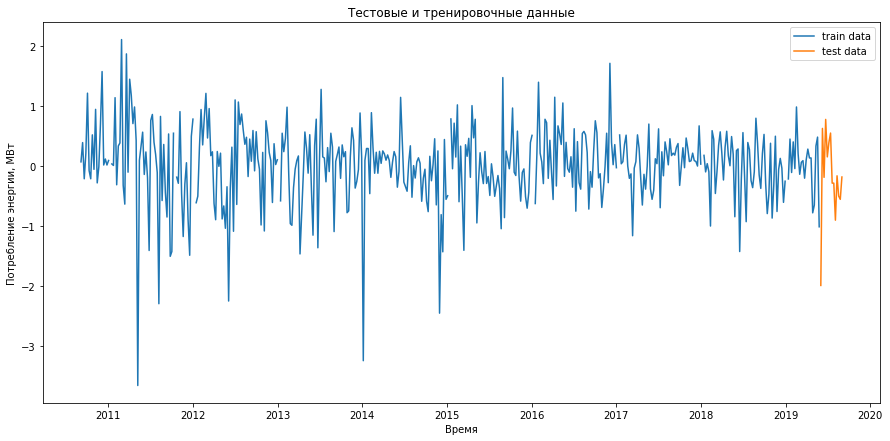

In [56]:
train, test = split_data(total_w, '06-01-2019')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [123]:
X_train = train.loc[:, train.columns != 'Значение']
Y_train = train['Значение']
X_test = test.loc[:, train.columns != 'Значение']
Y_test = test['Значение']

Билиотека GradientBoostingRegressor не поддерживает тип данных float64. Преобразуем тип данных в датафреймах

In [124]:
X_train[['curs_usd','curs_euro']] = X_train[['curs_usd','curs_euro']].astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_test[['curs_usd','curs_euro']] = X_test[['curs_usd','curs_euro']].astype(np.float32)
Y_test = Y_test.astype(np.float32)

In [125]:
X_train = X_train.dropna()
Y_train = Y_train.dropna()
X_test = X_test.dropna()
Y_test = Y_test.dropna()

Произведем прогноз

In [95]:
model_brent = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=200)

In [127]:
model_brent.fit( X_train, Y_train ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [128]:
Y_test_pred= model_brent.predict(X_test)

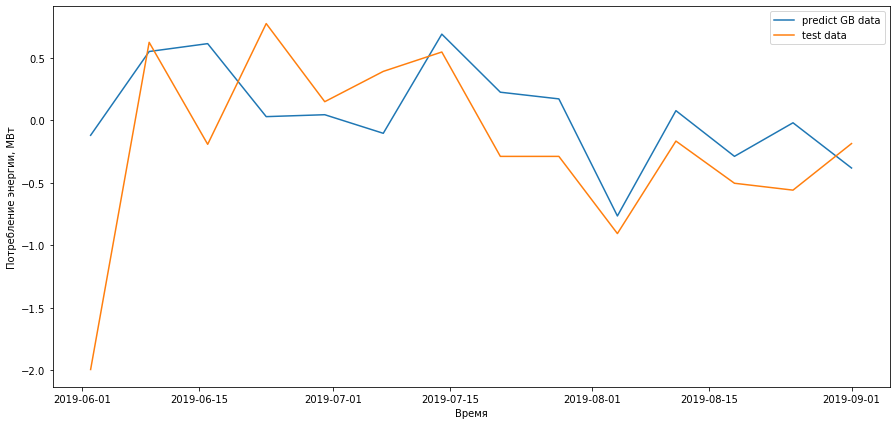

In [129]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(Y_test.index,Y_test_pred, label='predict GB data' )
plt.plot(Y_test.index,Y_test, label='test data')

plt.legend()
plt.show()

Рассчитаем метрики

In [131]:
er_s_1 = mean_squared_error(Y_test, Y_test_pred) 
er_a_1 = mean_absolute_error(Y_test, Y_test_pred) 
er_r2_1 = r2_score(Y_test, Y_test_pred)

print('ошибка mse :  ', er_s_1,'\nошибка mae  :  ', er_a_1,'\nоценка R2 :  ', er_r2_1)

ошибка mse :   0.4232009926770394 
ошибка mae  :   0.4676250644856426 
оценка R2 :   0.10317732720731554


<b>Вывод</b>: при использовании временного ряда с первыми разностями уменьшает значения ошибок, а также коэффициент детерминации